In [3]:
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Lambda,Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Sequential  #用來啟動 NN
from tensorflow.keras.layers import Conv2D  # Convolution Operation
from tensorflow.keras.layers import MaxPooling2D # Pooling
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense # Fully Connected Networks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate, AveragePooling2D, UpSampling2D, add, Multiply, GlobalAveragePooling2D
import tensorflow.keras as keras  
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import os
import random
import re
import time
from random import shuffle

In [4]:
def data_collect(Path):
    files=os.listdir(Path)
    random.shuffle(files)
    Train_Lstm=[]
    Label=[]
    Train=[]
    Train
    count=1
    Train_Pdf=[]
    for file in files:
        start=time.time()
        Break=0
        global Train_pdf, Label_Pdf
        Train_lstm=[]
        file_data=os.listdir(Path+file)
        
        ##CNN_PDF
        #CSFV2
        df_csfv2 = pd.read_csv(Path+file+'/'+file_data[0],header=None)
        df_era5 = pd.read_csv(Path+file+'/'+file_data[1],header=None)
        for column in df_csfv2.columns[2:7]:
            if column == df_csfv2.columns[2]:
                Train_pdf=np.array(np.array(df_csfv2[column]).reshape(61,101,1))
            else:
                Train_pdf=np.append(Train_pdf,np.array(df_csfv2[column]).reshape(61,101,1),axis=2)
                
        #ERAF
        for column in df_era5.columns[2:12]:
            Train_pdf=np.append(Train_pdf,np.array(df_era5[column]).reshape(61,101,1),axis=2)

        ##LSTM
        #ERA5
        df_1 = pd.read_csv(Path+file+'/'+file_data[3])
        for column in df_1.columns[1:91]:
            if' NaN' in list(df_1[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_1[column]))
            
        #CSFV2
        df_2 = pd.read_csv(Path+file+'/'+file_data[2])
        for column in df_2.columns[1:181]:
            if' NaN' in list(df_2[column])[:]:
                Break=1
                break
            Train_lstm.append(list(df_2[column]))
        if Break==1:
            continue

        ##LABEL_PDF 
        for column in df_era5.columns[7:17]:
            if column == df_era5.columns[7]:
                Label_Pdf=np.array(np.array(df_era5[column]).reshape(61,101,1))
                #print(Label_Pdf)
            else:
                Label_Pdf=np.append(Label_Pdf,np.array(df_era5[column]).reshape(61,101,1),axis=2)

        Train_Pdf.append(Train_pdf)
        Train_Lstm.append(Train_lstm)
        Label.append(Label_Pdf)
        end=time.time()
        Time=(end-start)*(len(files)-count)
        print('%d / %d , Time : %d : %d : %d'%(count,len(files),int(Time/3600),int(Time%3600/60),Time%3600%60),end='\r')
        count=count+1
    Train.append(Train_Pdf)
    Train.append(Train_Lstm)
    Label=np.array(Label)
    return Train,Label

In [5]:
#資料位置
Path='Data/Train/'

#模型儲存位置
Path_model = 'Model/LSMT_Restnet_new_data_my_loss_only_CNN_180days.h5'

#載入資料
Train,Label=data_collect(Path)

In [6]:
def squeeze_excitation(out_dim, nb_filter):
    def f(input):
        squeeze = GlobalAveragePooling2D()(input)
        excitation = Dense(int(out_dim/2), activation='relu')(squeeze)
        excitation = Dense(out_dim, activation='sigmoid')(excitation)
        excitation = Reshape((1,1,out_dim))(excitation)
        return Multiply()([input, excitation])
    return f


def squeeze_excitation_layer(out_dim, nb_filter):
    def f(input):
        input = squeeze_excitation(out_dim, nb_filter)(input)
        return input
    return f

In [34]:
def Conv2D_BN(inputs,filter,kernel,padding,stride):
    outputs = keras.layers.Conv2D(filters=filter,kernel_size=kernel,padding=padding,strides=stride,activation='relu')(inputs)
    outputs = keras.layers.BatchNormalization()(outputs)
    return outputs

def residual_block(inputs,filter,stride,whether_identity_change=False):
    x = Conv2D_BN(inputs, filter[0], kernel=(1,1), padding='same', stride=stride) 
    x = Conv2D_BN(x, filter[1], kernel=(3,3), padding='same', stride=1)
    x = Conv2D_BN(x, filter[2] ,kernel=(1,1), padding='same', stride=1)
    x = squeeze_excitation_layer(x.shape[-1], x.shape[-1])(x)
  # 累加必须保持尺寸一致，控制恒等层是否需要变channel数和压缩尺寸
    if whether_identity_change:
        identity = Conv2D_BN(inputs, filter[2], kernel=(1,1), padding='same', stride=stride)
        x = keras.layers.add([x,identity])
        return x
    else:
        x = keras.layers.add([x,inputs])
        return x
    
def ResNet():
  inputs = keras.Input(shape=(61, 101, 15))
  x = Conv2D_BN(inputs,64,(7,7),'same',2)
  x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')(x)

  x = residual_block(x,[64,64,256],1,True)
  x = residual_block(x,[64,64,256],1)
  x = residual_block(x,[64,64,256],1)

  x = residual_block(x,[128,128,512],2,True)
  x = residual_block(x,[128,128,512],1)
  x = residual_block(x,[128,128,512],1)
  x = residual_block(x,[128,128,512],1)

  x = residual_block(x,[256,256,1024],2,True)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)
  x = residual_block(x,[256,256,1024],1)

  x = residual_block(x,[512,512,2048],2,True)
  x = residual_block(x,[512,512,2048],1)
  x = residual_block(x,[512,512,2048],1) 
  x = keras.layers.AveragePooling2D(pool_size=(x.shape[1],x.shape[2]))(x)  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(10000,activation='relu')(x)
  x = Dense(10000, activation='relu')(x)
  x = Dense(101*61*10, activation='linear')(x)
  x = Reshape((61,101,10))(x)
  model = keras.Model(inputs=inputs,outputs=x)
  model.summary()
  return model


In [35]:
input_shape = (61, 101, 15)
model=ResNet()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 61, 101, 15) 0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 31, 51, 64)   47104       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_106 (BatchN (None, 31, 51, 64)   256         conv2d_106[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 16, 26, 64)   0           batch_normalization_106[0][0]    
_______________________________________________________________________________________

In [6]:
#資料轉換格式
Train_Pdf=Train[0]
Train_Lstm=Train[1]
Train_Pdf=np.array(Train_Pdf)
Train_Lstm=np.array(Train_Lstm)
print('Train_Lstm:',Train_Lstm.shape)
print('Train_Pdf:',Train_Pdf.shape)
Train_Pdf_List=Train_Pdf.tolist()

Train_Lstm: (2771, 270, 10)
Train_Pdf: (2771, 61, 101, 15)


In [7]:
#儲存最大、最小、平均值
Max=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Min=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000]
Mean=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
count=0
for i in range(len(Train_Pdf_List)):
    for j in range(len(Train_Pdf_List[0])):
        for x in range(len(Train_Pdf_List[0][0])):
            for y in range(len(Train_Pdf_List[0][0][0])):
                if Train_Pdf_List[i][j][x][y]>Max[y]:
                    Max[y]=Train_Pdf_List[i][j][x][y]
                if Train_Pdf_List[i][j][x][y]<Min[y]:
                    Min[y]=Train_Pdf_List[i][j][x][y]
                Mean[y]=Mean[y]+Train_Pdf_List[i][j][x][y] 
            count=count+1


In [8]:
Max=Max[:10]
Min=Min[:10]
Mean=Mean[:10]
for i in range(10):
    Mean[i]=Mean[i]/count

In [14]:
print('Mean:',Mean)
print('Max:',Max)
print('Min:',Min)

Mean: [287.3242734287198, 3.349621542723795, 293.65658980295865, 279.6666574399456, -0.25665387472126, 288.3584796428863, 3.2974777666300223, 294.7044402373835, 281.08416123969715, -0.15500007492913936]
Max: [307.9367, 17.7063, 313.7215, 304.4253, 3.8382, 310.1568, 18.0352, 314.7128, 306.1226, 2.7172]
Min: [232.6118, 0.1771, 244.0102, 204.4635, -4.7362, 234.9248, 0.1928, 248.2585, 220.1559, -4.1973]


In [29]:
def mcustom_loss(y_true, y_pred):

    trueAvg = (y_true[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    trueStd = (y_true[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    trueMax = (y_true[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    trueMin = (y_true[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    trueSkw = (y_true[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])

    predAvg = (y_pred[:,:,:,0][:,:,:,np.newaxis]-Mean[0])/(Max[0]-Min[0])
    predStd = (y_pred[:,:,:,1][:,:,:,np.newaxis]-Mean[1])/(Max[1]-Min[1])
    predMax = (y_pred[:,:,:,2][:,:,:,np.newaxis]-Mean[2])/(Max[2]-Min[2])
    predMin = (y_pred[:,:,:,3][:,:,:,np.newaxis]-Mean[3])/(Max[3]-Min[3])
    predSkw = (y_pred[:,:,:,4][:,:,:,np.newaxis]-Mean[4])/(Max[4]-Min[4])
    
    trueAvg_180 = (y_true[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    trueStd_180 = (y_true[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    trueMax_180 = (y_true[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    trueMin_180 = (y_true[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    trueSkw_180 = (y_true[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    predAvg_180 = (y_pred[:,:,:,5][:,:,:,np.newaxis]-Mean[5])/(Max[5]-Min[5])
    predStd_180 = (y_pred[:,:,:,6][:,:,:,np.newaxis]-Mean[6])/(Max[6]-Min[6])
    predMax_180 = (y_pred[:,:,:,7][:,:,:,np.newaxis]-Mean[7])/(Max[7]-Min[7])
    predMin_180 = (y_pred[:,:,:,8][:,:,:,np.newaxis]-Mean[8])/(Max[8]-Min[8])
    predSkw_180 = (y_pred[:,:,:,9][:,:,:,np.newaxis]-Mean[9])/(Max[9]-Min[9])

    loss = ((K.square(predMin - trueMin) + K.square(predMax - trueMax) + K.square(predSkw - trueSkw) +
            K.square(predAvg - trueAvg) + K.square(predStd - trueStd))+
            (K.square(predMin_180 - trueMin_180) + K.square(predMax_180 - trueMax_180) + K.square(predSkw_180 - trueSkw_180) +
            K.square(predAvg_180 - trueAvg_180) + K.square(predStd_180 - trueStd_180)))/10
    loss = K.mean(loss, axis=-1)

    return loss

In [36]:
model_checkpoint_callback=ModelCheckpoint(Path_model, monitor='val_loss', verbose=1, save_best_only=True)
model.compile(optimizer = 'adam', loss = mcustom_loss,run_eagerly=True)

histroy=model.fit([Train_Pdf],Label,
          batch_size=16,
          #validation_data=([Valid_Pdf,Valid_Lstm],Valid_Label),
          validation_split=0.2,
          epochs=100,
          callbacks=[model_checkpoint_callback]
         )

Epoch 1/100
139/139 [==============================] - ETA: 0s - loss: 1.5636
Epoch 00001: val_loss improved from inf to 2.34439, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_CNN_180days.h5
139/139 [==============================] - 667s 5s/step - loss: 1.5636 - val_loss: 2.3444
Epoch 2/100
139/139 [==============================] - ETA: 0s - loss: 0.0242
Epoch 00002: val_loss improved from 2.34439 to 0.25159, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_CNN_180days.h5
139/139 [==============================] - 403s 3s/step - loss: 0.0242 - val_loss: 0.2516
Epoch 3/100
139/139 [==============================] - ETA: 0s - loss: 0.0120
Epoch 00003: val_loss improved from 0.25159 to 0.00813, saving model to D:/weather/model\LSMT_Restnet_new_data_my_loss_only_CNN_180days.h5
139/139 [==============================] - 415s 3s/step - loss: 0.0120 - val_loss: 0.0081
Epoch 4/100
139/139 [==============================] - ETA: 0s - loss: 0.0216
Epoch

139/139 [==============================] - 414s 3s/step - loss: 0.0035 - val_loss: 0.0020
Epoch 72/100
139/139 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00072: val_loss did not improve from 0.00198
139/139 [==============================] - 354s 3s/step - loss: 0.0026 - val_loss: 0.0062
Epoch 73/100
139/139 [==============================] - ETA: 0s - loss: 0.0029
Epoch 00073: val_loss did not improve from 0.00198
139/139 [==============================] - 356s 3s/step - loss: 0.0029 - val_loss: 0.0167
Epoch 74/100
139/139 [==============================] - ETA: 0s - loss: 0.0035
Epoch 00074: val_loss did not improve from 0.00198
139/139 [==============================] - 355s 3s/step - loss: 0.0035 - val_loss: 0.0075
Epoch 75/100
139/139 [==============================] - ETA: 0s - loss: 0.0031
Epoch 00075: val_loss did not improve from 0.00198
139/139 [==============================] - 355s 3s/step - loss: 0.0031 - val_loss: 0.0047
Epoch 76/100
139/139 [========

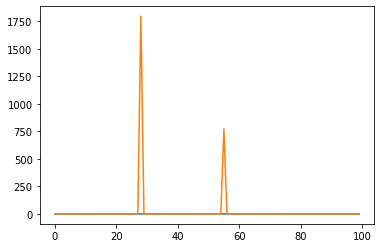

In [39]:
import matplotlib.pyplot as plt
plt.plot(histroy.history['loss']) 
plt.plot(histroy.history['val_loss']) 